Course:
<br>https://aleksandarhaber.com/extended-kalman-filter-tutorial-with-example-and-disciplined-python-codes-part-ii-python-codes/

### Import libraries 

In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import expm
import scipy
import math
import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

np.set_printoptions(suppress=True)
%matplotlib inline

### Problem statement

<br>
We have a pendulum swinging on the rope. We will create simulation. As you can see from formula bellow, we should use sinus, which means, that we would be dealing with non linear system. For cases, where angle is bellow 15 degrees, we can approximate this value into linear system as is written in last formula
</br>
<img src="https://thecuriousastronomer.files.wordpress.com/2013/10/20131022-110640.jpg"  width = 300 height=300 />
</br>
<i>https://thecuriousastronomer.files.wordpress.com/2013/10/20131022-110640.jpg</i>


Firstly we define object of vehicle, where we will store all data

Then we run simulation of measurement and display real value pendulum swing

In [2]:
def run_simulation(starting_angle:int=15,
                    length_of_rope:float = 10,
                    end_time:int = 10,
                    dt:float = 0.01,
                    g:float = 9.81, 
                    ):
    theta0 = np.deg2rad(starting_angle)

    # Set Initial State
    x0 = np.array([theta0,0])

    # total simulation time 
    totalSimulationTimeVector=np.arange(0,end_time,dt)

    # this state-space model defines the continuous dynamics of the pendulum
    # this function is passed as an argument of the odeint() function for integrating (solving) the dynamics 
    def stateSpaceModel(x,t):
        g=9.81
        # 
        l=1
        dxdt=np.array([x[1],-(g/l)*np.sin(x[0])])
        return dxdt

    # here we integrate the dynamics
    # the output: "solutionOde" contains time series of the angle and angular velocity 
    # these time series represent the time series of the true state that we want to estimate
    simulation_state_history=scipy.integrate.odeint(stateSpaceModel,x0,totalSimulationTimeVector)
    
    # here we compare the forward Euler discretization with the odeint()
    # this is important for evaluating the accuracy of the forward Euler method 

    forwardEulerState=np.zeros(shape=(len(totalSimulationTimeVector),2))
    # set the initial states to match the initial state used in the odeint()
    forwardEulerState[0,0]=x0[0]
    forwardEulerState[0,1]=x0[1]

    # propagate the forward Euler dynamics
    for timeIndex in range(len(totalSimulationTimeVector)-1):
        forwardEulerState[timeIndex+1,:]=forwardEulerState[timeIndex,:]+dt*stateSpaceModel(forwardEulerState[timeIndex,:],timeIndex*dt)

    return simulation_state_history, forwardEulerState

In [3]:
simulation_state_history, forwardEulerState_ = run_simulation(    
                   starting_angle=35,
                   length_of_rope=1,
                   end_time = 20, 
                   dt=0.0001)

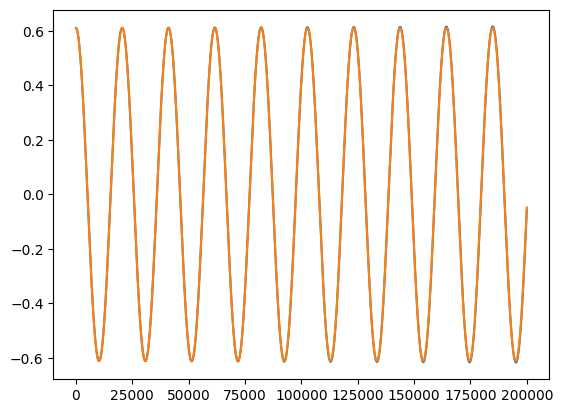

In [4]:
plt.figure()
plt.plot(forwardEulerState_[:, 0])
plt.plot(simulation_state_history[:, 0])
plt.show()

### Implement KF base

In [5]:
# Definition of Kalman filter
class KalmanFilterBase:
    def __init__(self):
        # variables we would like to track
        self.state = None
        self.covariance = None
        self.innovation = None
        self.innovation_covariance = None

    def get_current_state(self):
        if self.state is not None:
            return self.state.tolist()
        return None

    def get_current_covariance(self):
        if self.covariance is not None:
            return self.covariance.tolist()
        return None

    def get_last_innovation(self):
        if self.innovation is not None:
            return self.innovation.tolist()
        return None

    def get_last_innovation_covariance(self):
        if self.innovation_covariance is not None:
            return self.innovation_covariance.tolist()
        return None

### Implement UKF predict

In [191]:
# Kalman Filter Model
class KalmanFilterPredict(KalmanFilterBase):

    def initialise(
        self,
        initial_state,
        time_step,
        angle_std,
        angular_velocity_std,
        meas_std,
        length,
        init_on_measurement=False,
        init_pos_std=0.1,
        init_vel_std=0.1,
    ):
        self.dT = time_step
        self.init_pos_std = init_pos_std
        self.init_vel_std = init_vel_std
        self.g = 9.81
        self.l = length

        # Set R and Q Matrices
        self.Q = np.diag(
            np.array([angle_std * angle_std, angular_velocity_std * angular_velocity_std])
        )  # Note: use variable 'torque_std' and 'angle_std'
        #self.Q = np.zeros((2,2))
        self.R = np.array([[meas_std*meas_std]]) # Note: use variable 'meas_std'

        # Set Initial State and Covariance
        if init_on_measurement is False:
            self.state = initial_state
            self.covariance = np.diag(np.array([init_pos_std*init_pos_std,init_vel_std*init_vel_std]))

        # Define variables between Predict and Update
        self.output_state = None
        self.output_sigmas = None
        self.x_sigmas_propagated = None
        self.x_sigmas_propagated2y = None
        self.x_mean = None
        self.y_mean = None
        self.W0m = None
        self.W0c = None
        self.Wi = None

    # here is the continuous state-space model
    # inputs:
    #       x - state vector
    #       t - time
    # NOTE THAT WE ARE NOT USING time since the dynamics is time invariant
    # output:
    #       dxdt - the value of the state function (derivative of x)
    def stateSpaceContinuous(self,x):
        dxdt=np.array([[x[1,0]],[-(self.g/self.l)*np.sin(x[0,0])]])
        return dxdt

    # this function defines the discretized state-space model
    # we use the forward Euler discretization
    # input:
    #       x_k   - current state x_{k}
    # output:
    #       x_kp1 - state propagated in time x_{k+1}
    def discreteTimeDynamics(self,x_k):
        # note over here that we are not using "self.currentTimeStep*self.DT" since the dynamics is time invariant
        # however, you might need to use this argument if your dynamics is time varying
        x_kp1=x_k+self.dT*self.stateSpaceContinuous(x_k)
        return x_kp1

    # this function returns the Jacobian of the discrete-time state equation
    # evaluated at x_k
    # That is, it returns the matrix A
    # input:
    #       x_k - state
    # output:
    #       A - the Jacobian matrix of the state equation with respect to state

    def output_propagation(self, x_k):
        return np.matmul(x_k.T, np.array([[1, 0],[0,0]])).T

    def get_sigma_points(self, x, P, state_dim, n_sigma, lambda_calc):

        '''
        generating sigma points matrix x_sigma given mean 'x' and covariance 'P'
        '''

        # Create sigma arrays with zeros
        x_sigma = np.zeros((state_dim, n_sigma))  
        x_sigma[:, 0] = x.reshape(-1)

        x = x.reshape(state_dim, )

        # Calculate sqrt of P
        P_sqrt = np.linalg.cholesky(P)

        # Get sigma scaler
        scaler = np.sqrt(state_dim + lambda_calc)
        # print(f"scaler {scaler}")

        for index in range(state_dim):
            x_sigma[:, index+1]        = x + (scaler * P_sqrt[:, index])
            x_sigma[:, index+state_dim+1] = x - (scaler * P_sqrt[:, index])

        # print(f"x_sigmas {x_sigma}")
        return x_sigma, lambda_calc

    def calculate_mean_and_covariance(self, y_sigmas, n_sigma, W0m, W0c, Wi):       
        # mean calculation
        y = W0m * y_sigmas[:, 0]
        for i in range(1, n_sigma):
            y += Wi * y_sigmas[:, i]
        y = y.reshape(-1,1)

        # covariance calculation
        sigma_point = y_sigmas[:, 0].reshape(-1, 1)
        Py = W0c * np.matmul((sigma_point - y), (sigma_point - y).T)
        for i in range(1, n_sigma):
            sigma_point = y_sigmas[:, i].reshape(-1, 1)
            Py += Wi * np.matmul((sigma_point - y), (sigma_point - y).T)

        return y, Py

    def prediction_step(self):
        # Make Sure Filter is Initialised
        if self.state is not None:
            x = self.state
            P = self.covariance

            # Get dimensions for sigma
            state_dim = np.shape(x)[0] # State dimension

            # Get number of sigmas
            self.n_sigma = (2 * state_dim) + 1

            # Calculate
            kappa = 0
            alpha = 1
            betta = 0
            lambda_calc = (alpha**2)*(state_dim + kappa) - state_dim

            # get sigma points
            sigma_points, lambda_calc = self.get_sigma_points(x, P, state_dim, self.n_sigma, lambda_calc)

            # Get weights for sigma points
            self.W0m = lambda_calc / (state_dim + lambda_calc)
            self.W0c = lambda_calc / (state_dim + lambda_calc) + (1 - alpha**2 + betta)
            self.Wi = 1/(2*(state_dim + lambda_calc))

            # Transform sigmas
            transformed_sigmas = np.zeros_like(sigma_points)
            for sigma_id in range(sigma_points.shape[1]):
                transformed_sigma = self.discreteTimeDynamics(sigma_points[:,sigma_id].reshape(-1,1)).reshape(-1)
                transformed_sigmas[:,sigma_id] = transformed_sigma

            # Get mean and covariance
            new_state, new_covariance = self.calculate_mean_and_covariance(
                transformed_sigmas, self.n_sigma, self.W0m, self.W0c, self.Wi
            )

            # print(f"x {x}")
            # print(f"x {x.shape}")

            # print(f"transformed_sigmas {transformed_sigmas}")
            # print(f"transformed_sigmas {transformed_sigmas.shape}")

            output_sigmas = self.output_propagation(transformed_sigmas)
            # print(f"output_sigmas {output_sigmas}")
            # print(f"output_sigmas {output_sigmas.shape}")
            output_state,_ = self.calculate_mean_and_covariance(
                output_sigmas, self.n_sigma, self.W0m, self.W0c, self.Wi
            )
            # print(f"output_state {output_state}")
            # print(f"output_state {output_state.shape}")

            # Save Predicted State
            self.state = new_state
            self.covariance = new_covariance + self.Q

            # Save other states
            self.x_sigmas_propagated = transformed_sigmas
            self.x_mean = new_state
            self.output_sigmas = output_sigmas[0,:]
            self.output_state = output_state[0,0]

        return

In [178]:
kf_options = {
    "angular_velocity_std": 0.00001,  # Q [] Matrix
    "angle_std": 0.0001,  # Q [] Matrix
    "meas_std": np.deg2rad(1),  # R Matrix
    "initial_state": np.array([[np.deg2rad(35)], [0.0]]),  # Degrees
    "init_pos_std": np.deg2rad(0.0001),
    "init_vel_std": np.deg2rad(0.0001),
    "init_on_measurement": False,
    "time_step": 0.0001,
    "length": 1,
}

In [179]:
simulation_state_history, forwardEulerState = run_simulation(
    starting_angle=np.rad2deg(kf_options["initial_state"][0]).item(),
    length_of_rope=kf_options["length"],
    end_time=20,
    dt=kf_options["time_step"],
)

In [180]:
kalman_filter = KalmanFilterPredict()
kalman_filter.initialise(**kf_options)
states = []
covariances = []
estimation_errors = []
#for step_id in tqdm.tqdm(range(len(simulation_state_history))):
for step_id in tqdm.tqdm(range(2)):
    kalman_filter.prediction_step()
    states.append(kalman_filter.get_current_state())
    covariances.append(kalman_filter.get_current_covariance())
    estimation_errors.append(np.array(kalman_filter.get_current_state()) 
                             - np.array(simulation_state_history[step_id]))

states = np.array(states)
covariances = np.array(covariances)
estimation_errors = np.array(estimation_errors)

100%|██████████| 2/2 [00:00<00:00, 3233.85it/s]


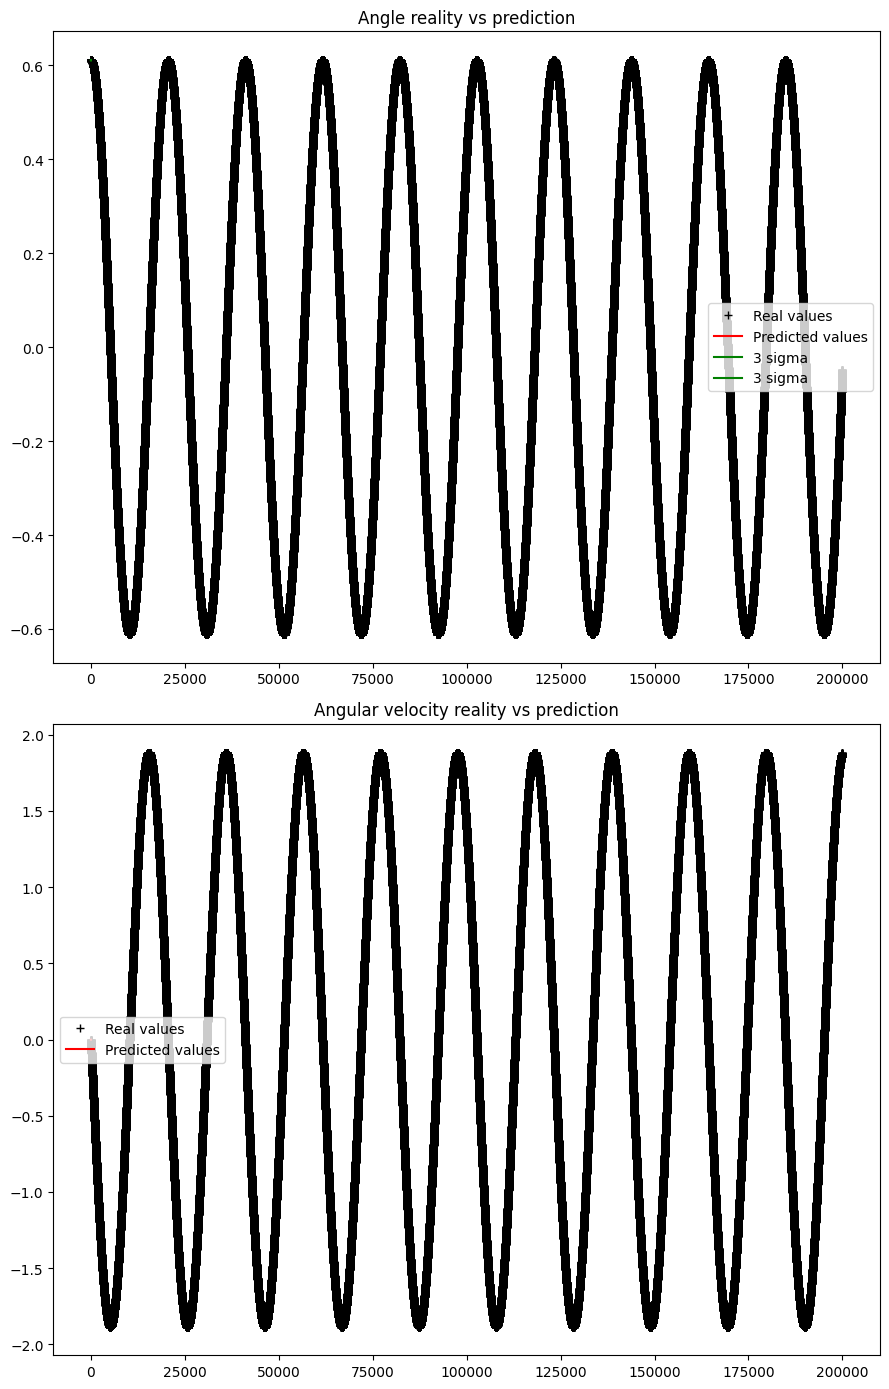

In [181]:
lin_state_history = np.array(simulation_state_history)
states = np.array(states)
%matplotlib inline
fig, ax = plt.subplots(2,1,figsize = (9,14))

ax[0].plot(lin_state_history[:,0], "+k", label = "Real values")
ax[0].plot(states[:,0], "-r", label = "Predicted values")
ax[0].legend()
ax[0].set_title("Angle reality vs prediction")

ax[0].plot(states[:,0].reshape(-1) + np.sqrt(covariances[:,0,0])*3, "-g", label = "3 sigma")
ax[0].plot(states[:,0].reshape(-1) - np.sqrt(covariances[:,0,0])*3, "-g", label = "3 sigma")
ax[0].legend()

ax[1].plot(lin_state_history[:,1], "+k", label = "Real values")
ax[1].plot(states[:,1], "-r", label = "Predicted values")
ax[1].legend()
ax[1].set_title("Angular velocity reality vs prediction")




plt.tight_layout()
plt.show()

### Implement UKF Update

In [413]:
class KalmanFilterModel(KalmanFilterPredict):
    def __init__(self):
        super().__init__()

    def update(self, measurement):
        # Calculate covariance of Y and yhat
        """
        (rows, columns)
        Calculated as np.matmul((sigma with shape (2,1) - self.output_state with shape (2,1)), (sigma with shape (2,1) - self.output_state with shape (2,1)).T)

        Output shape is then 4x4. 

        As output_state is alway (position,0) as we are 
        """
        sigma_points_y = self.output_sigmas#.reshape(-1, 1)
        sigma_point_y = sigma_points_y[0].reshape(-1,1)
        Pykyk = self.W0c * np.matmul(
            (sigma_point_y - self.output_state).reshape(-1,1), (sigma_point_y - self.output_state).reshape(-1,1).T
        )
        for i in range(1, self.n_sigma):
            sigma_point_y = sigma_points_y[i].reshape(-1, 1)
            Pykyk += self.Wi * np.matmul(
                (sigma_point_y - self.output_state).reshape(-1, 1),
                (sigma_point_y - self.output_state).reshape(-1, 1).T,
            )
        Pykyk += self.R
        # Calculate covariance of X and y
        sigma_points_x = self.x_sigmas_propagated#.reshape(-1, 1)
        sigma_point_x = sigma_points_x[:,0].reshape(-1, 1)
        sigma_point_y = sigma_points_y[0].reshape(-1, 1)
        Pxkyk = self.W0c * np.matmul(
            (sigma_point_x - self.x_mean), (sigma_point_y - self.output_state).T
        )
        for i in range(1, self.n_sigma):
            sigma_point_x = sigma_points_x[:,i].reshape(-1, 1)
            sigma_point_y = sigma_points_y[i].reshape(-1, 1)
            Pxkyk += self.Wi * np.matmul((sigma_point_x - self.x_mean), (sigma_point_y - self.output_state).T)
        # Calculate Kappa for update
        kappa = np.matmul(Pxkyk, np.linalg.inv(Pykyk))
        # Calculate update
        update = kappa * (measurement[0]- self.output_state)
        self.state += update
        # Calculate new variance
        self.covariance = self.covariance - np.matmul(kappa, Pykyk *  kappa.T)

In [414]:
kf_options = {
    "angular_velocity_std": 0.1,  # Q [] Matrix
    "angle_std": 0.01,  # Q [] Matrix
    "meas_std": 0.01,  # R Matrix
    "initial_state": np.array([[np.deg2rad(15)], [0.0]]),  # Degrees
    "init_pos_std": np.deg2rad(20),
    "init_vel_std": np.deg2rad(20),
    "init_on_measurement": False,
    "time_step": 0.0001,
    "length": 1,
}

In [415]:
simulation_state_history, forwardEulerState = run_simulation(
    starting_angle=np.rad2deg(kf_options["initial_state"][0]).item(),
    length_of_rope=kf_options["length"],
    end_time=20,
    dt=kf_options["time_step"],
)

In [416]:
kf_options["initial_state"] = np.array([[np.deg2rad(25)], [0.0]])
kalman_filter = KalmanFilterModel()
kalman_filter.initialise(**kf_options)
for i in range(2):
    kalman_filter.prediction_step()
    kalman_filter.update(simulation_state_history[0])

In [417]:
simulation_state_history = simulation_state_history[:10000]

In [418]:
kalman_filter = KalmanFilterModel()
kalman_filter.initialise(**kf_options)
states = []
covariances = []
estimation_errors = []
for step_id in tqdm.tqdm(range(len(simulation_state_history))):
    # for step_id in tqdm.tqdm(range(2)):
    kalman_filter.prediction_step()
    states.append(kalman_filter.get_current_state())
    covariances.append(kalman_filter.get_current_covariance())
    kalman_filter.update(simulation_state_history[step_id])

states = np.array(states)
covariances = np.array(covariances)

100%|██████████| 10000/10000 [00:01<00:00, 7028.59it/s]


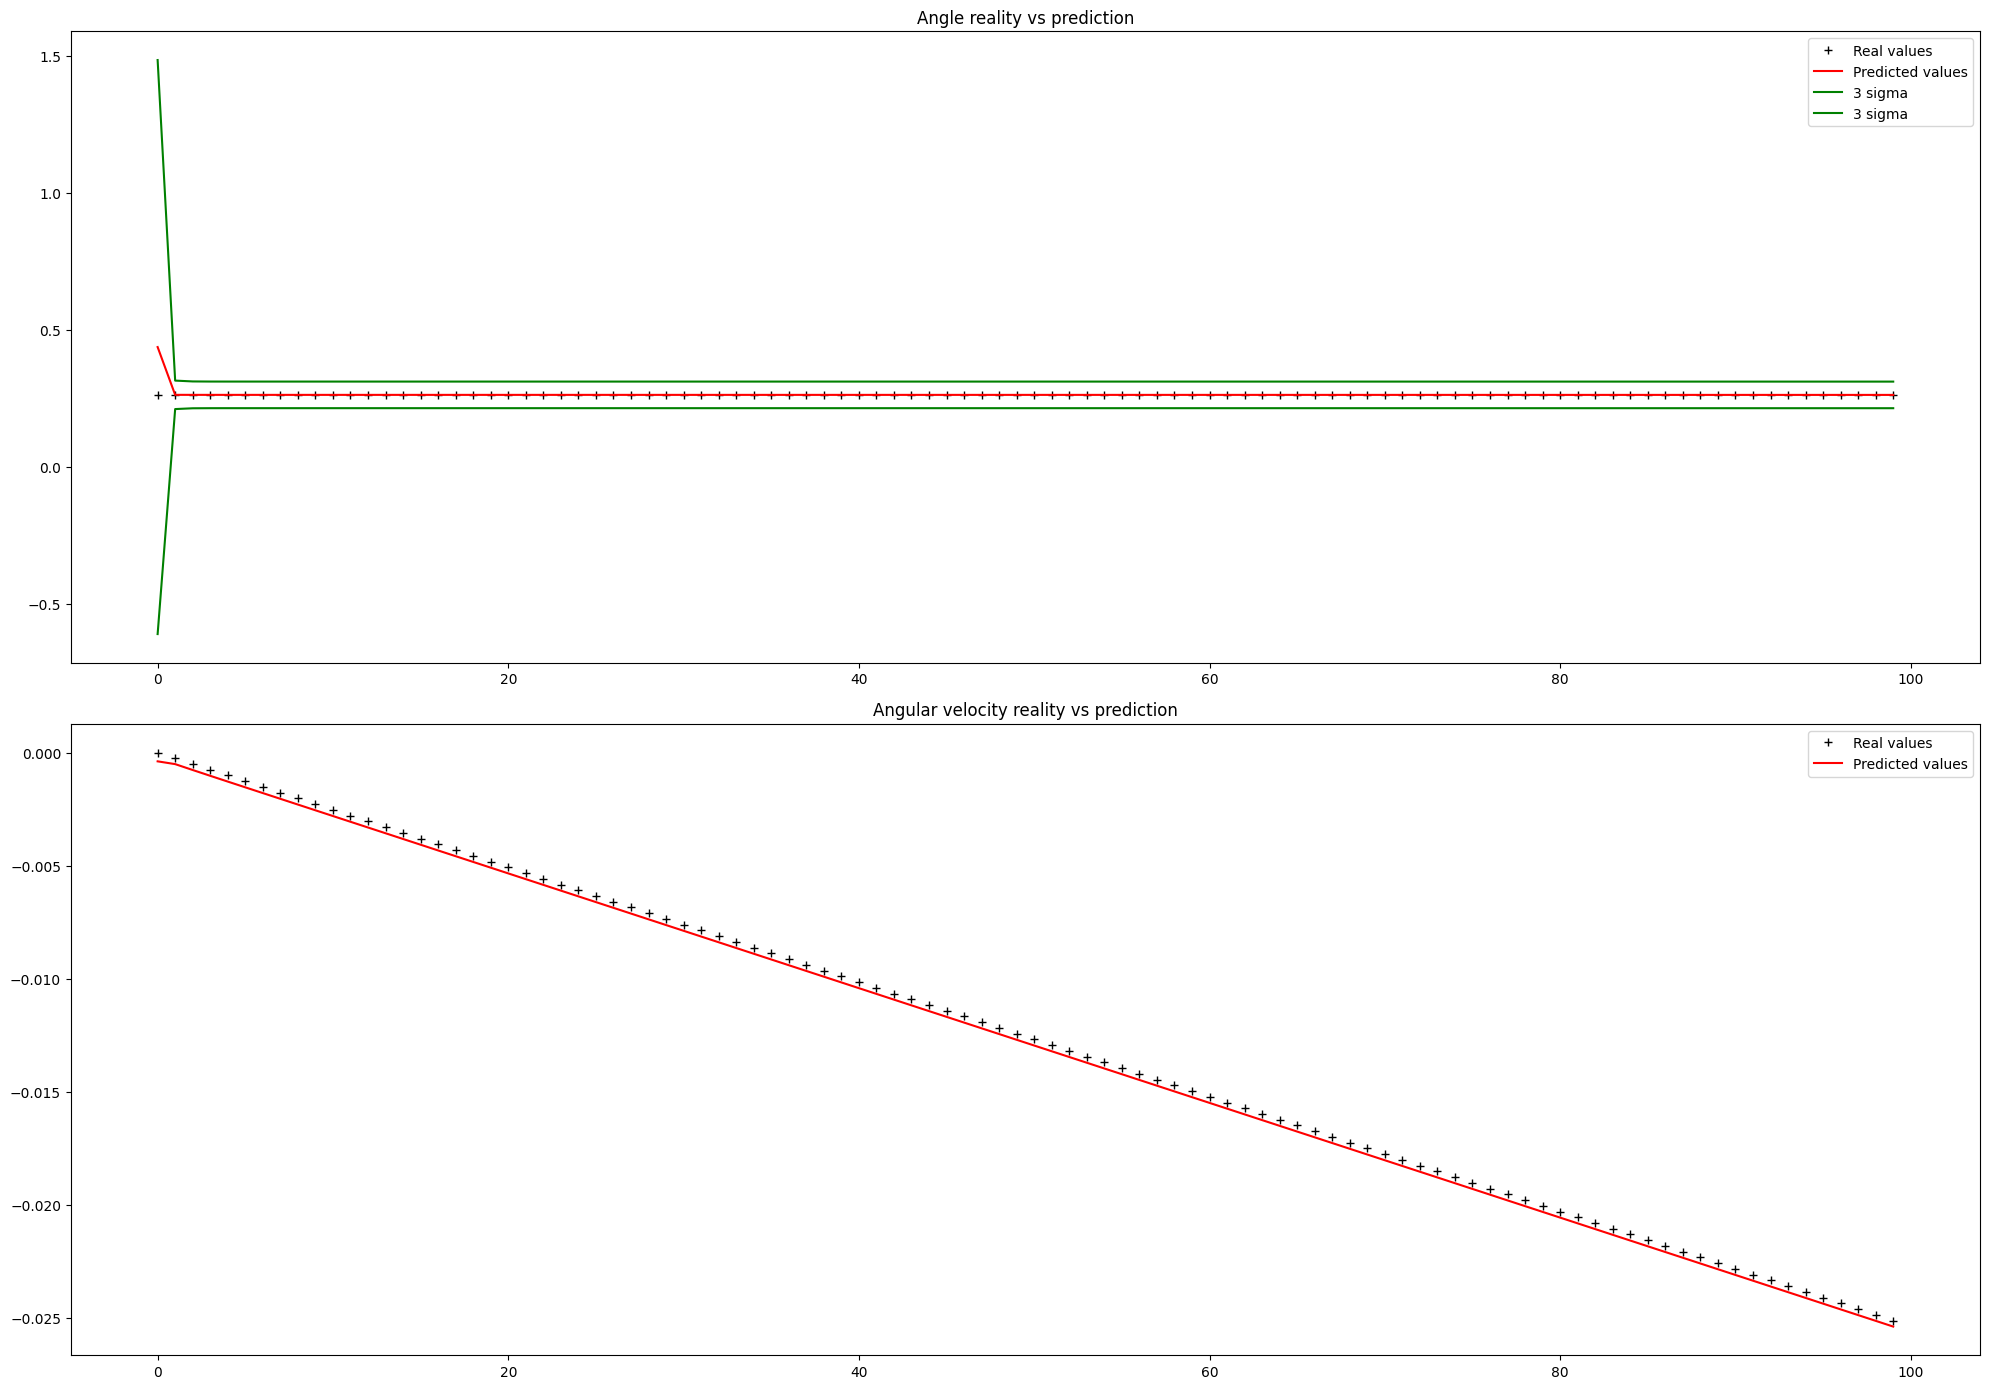

In [422]:
lin_state_history = np.array(simulation_state_history)
lim = 100
states = np.array(states)
%matplotlib inline
fig, ax = plt.subplots(2,1,figsize = (20,14))

ax[0].plot(lin_state_history[:lim,0], "+k", label = "Real values")
ax[0].plot(states[:lim,0], "-r", label = "Predicted values")
ax[0].legend()
ax[0].set_title("Angle reality vs prediction")

ax[0].plot(states[:lim,0].reshape(-1) + np.sqrt(covariances[:lim,0,0])*3, "-g", label = "3 sigma")
ax[0].plot(states[:lim,0].reshape(-1) - np.sqrt(covariances[:lim,0,0])*3, "-g", label = "3 sigma")
ax[0].legend()

ax[1].plot(lin_state_history[:lim,1], "+k", label = "Real values")
ax[1].plot(states[:lim,1], "-r", label = "Predicted values")
ax[1].legend()
ax[1].set_title("Angular velocity reality vs prediction")




plt.tight_layout()
plt.show()

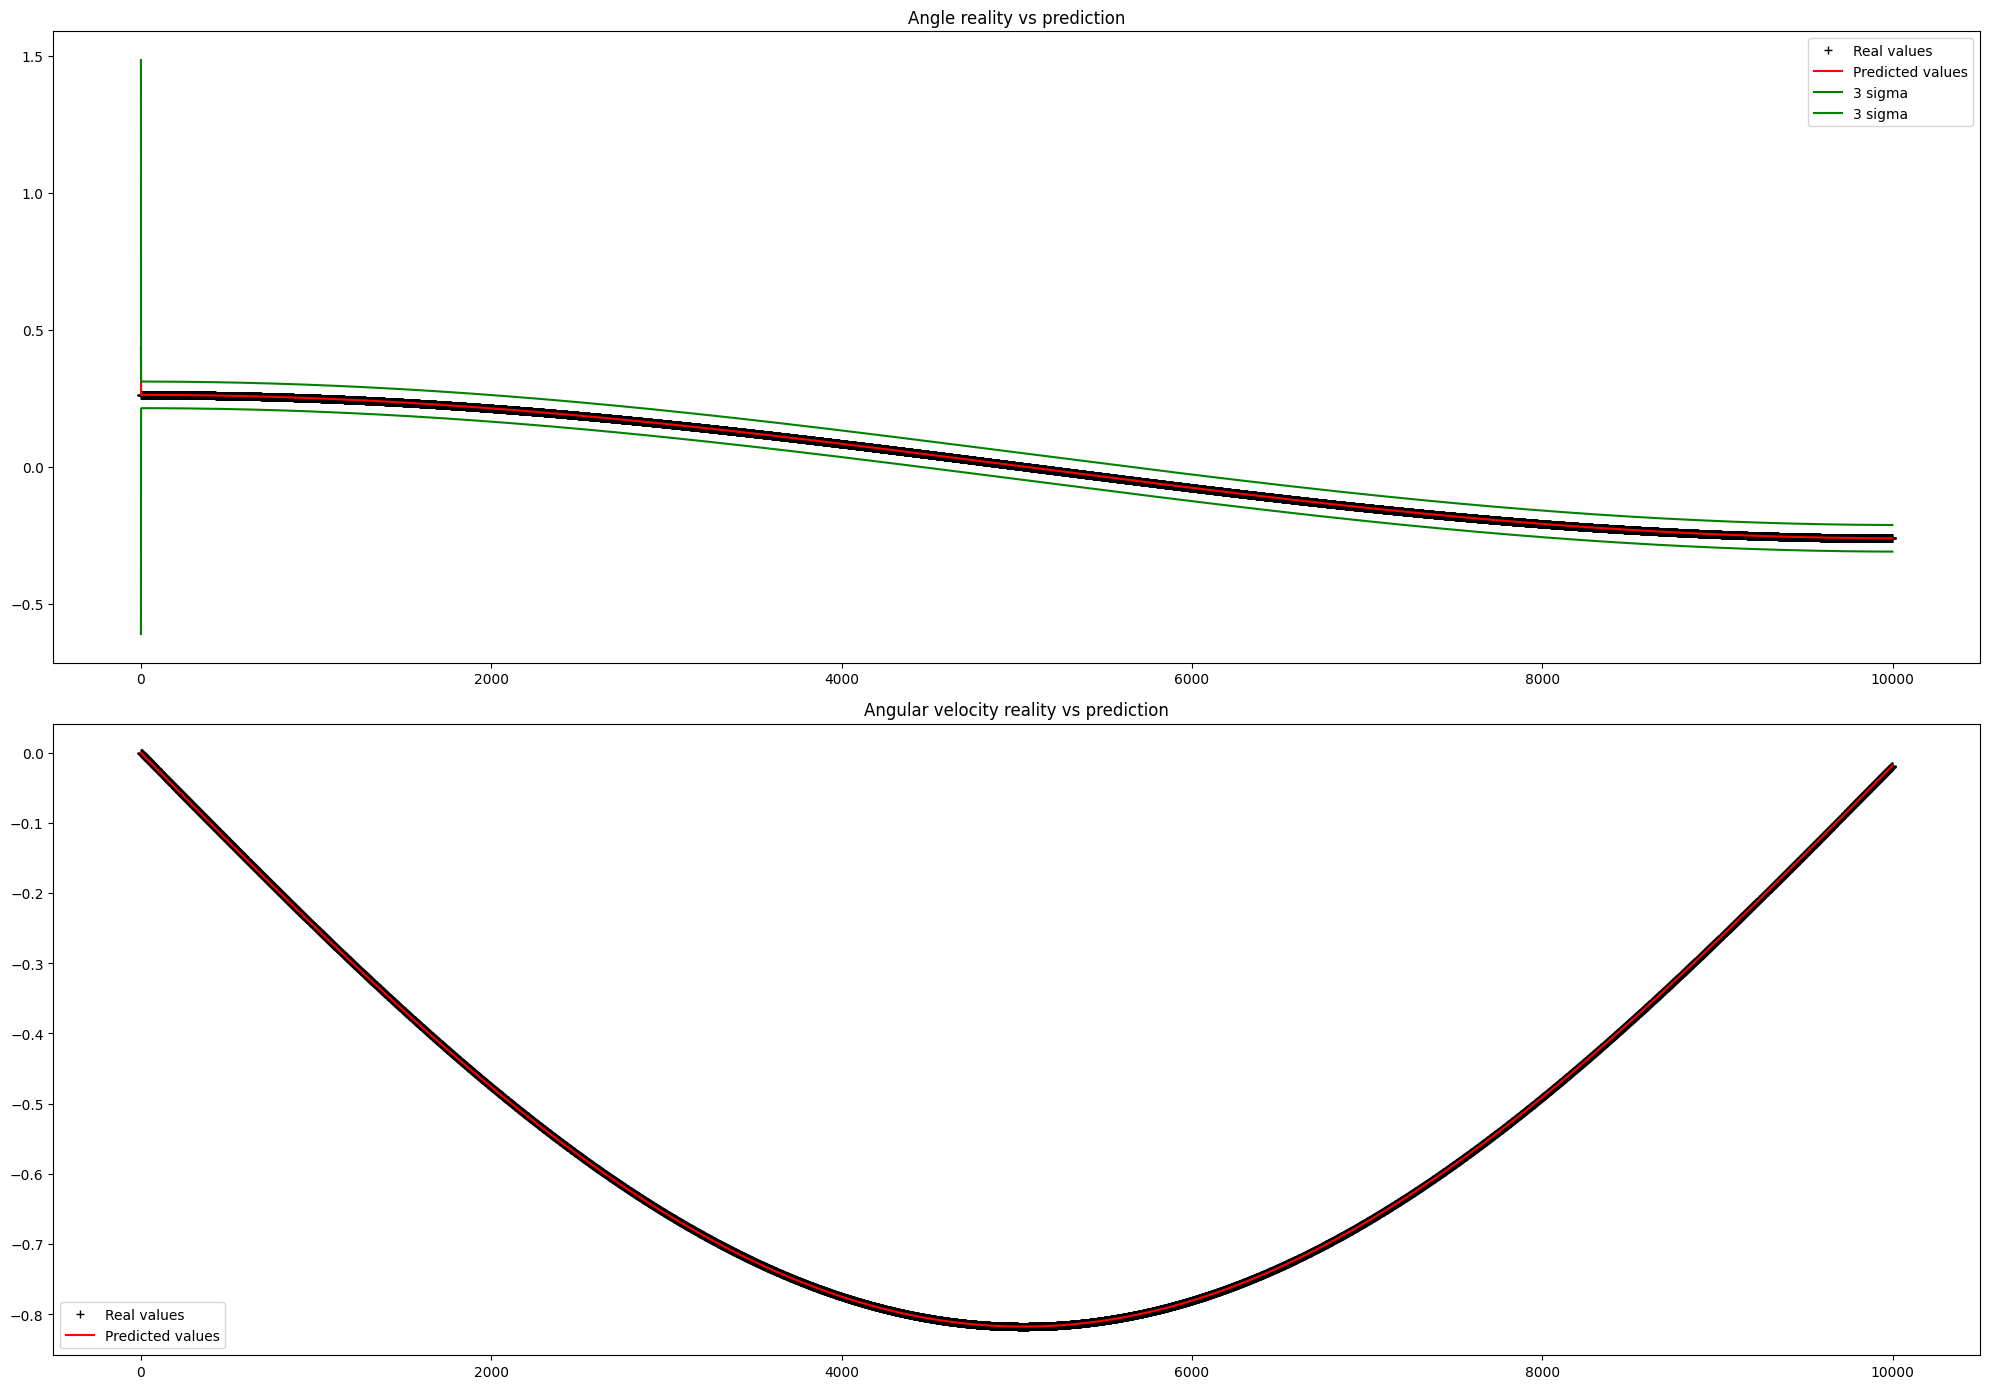

In [421]:
lin_state_history = np.array(simulation_state_history)
states = np.array(states)
%matplotlib inline
fig, ax = plt.subplots(2,1,figsize = (20,14))

ax[0].plot(lin_state_history[:,0], "+k", label = "Real values")
ax[0].plot(states[:,0], "-r", label = "Predicted values")
ax[0].legend()
ax[0].set_title("Angle reality vs prediction")

ax[0].plot(states[:,0].reshape(-1) + np.sqrt(covariances[:,0,0])*3, "-g", label = "3 sigma")
ax[0].plot(states[:,0].reshape(-1) - np.sqrt(covariances[:,0,0])*3, "-g", label = "3 sigma")
ax[0].legend()

ax[1].plot(lin_state_history[:,1], "+k", label = "Real values")
ax[1].plot(states[:,1], "-r", label = "Predicted values")
ax[1].legend()
ax[1].set_title("Angular velocity reality vs prediction")




plt.tight_layout()
plt.show()